In [4]:
# Calcula el onset en la Cuenca del Valle
# de México con información de CHIRPS.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

In [5]:
path_r = "../results/onset/"
fname_d = path_r  + "pre_daily_CHIRPS.csv"

df_mean = pd.read_csv(fname_d, index_col = "time")
df_mean.index = pd.to_datetime(df_mean.index)

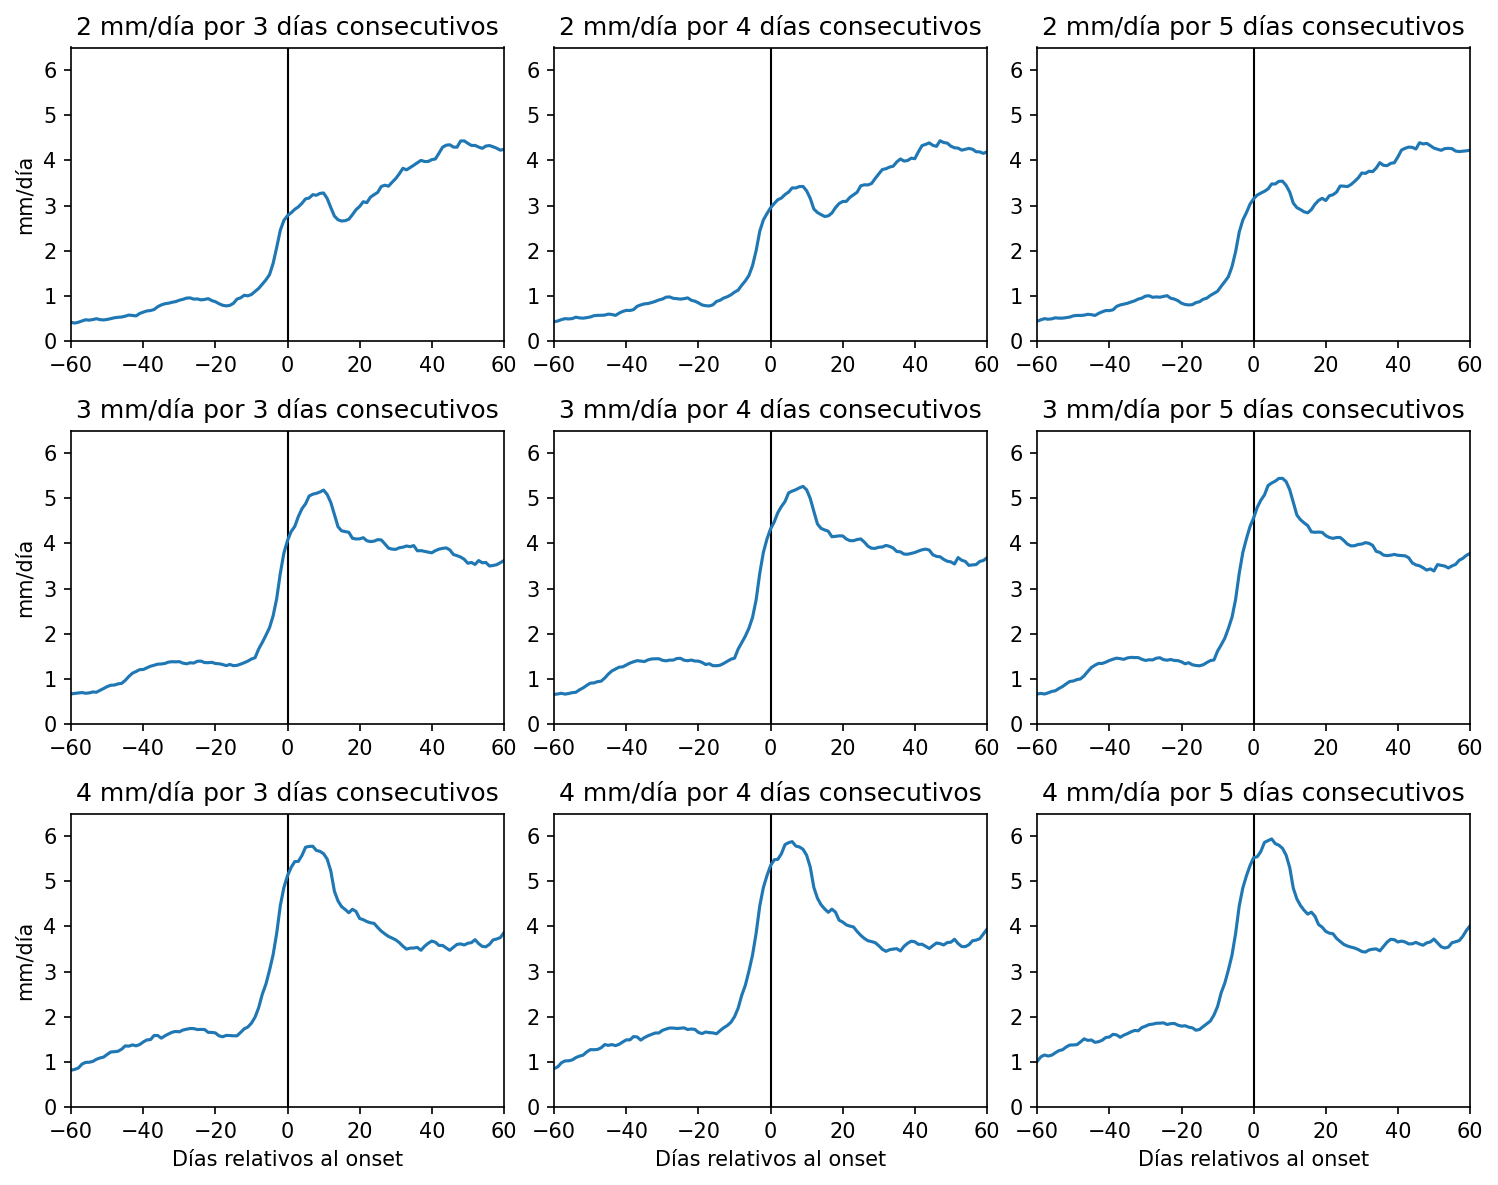

In [9]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2, 3, 4]
dias = [3, 4, 5]

n = 3

# Ajustes de gráficas múltiples.
fig, axes = plt.subplots(len(umbral), len(dias))
fig.set_size_inches(10, 8)
fig.set_dpi(150)

for i_n, n in enumerate(dias):
    for i_u, u in enumerate(umbral):
        df_mean_ind = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )

        c = "Cuenca"

        # Nombre de las columnas dummy.
        proc = [c]
        for i in range(0, n):
            proc.append(c +
                "_" + str(i)) 

        # Traslapa los últimos n días 
        # y da un valor de 1 a cada día 
        # que cumpla con el umbral.
        for i, p in enumerate(proc[1:]):
            df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
            df_mean_ind[p].clip( upper = u,
                inplace = True )
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] == u, 0)
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] < u, 1)

        # El índice es uno si los n
        # cumplen con el umbral.
        ind = "Index_" + c
        df_mean_ind[ind] = 0
        for i in range(n):
            df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] == n, 0)
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] < n, 1)
        df_mean_ind.drop(proc[1:],
            axis = 1, inplace = True)

        # Crea una tabla con los valores anuales.
        col = []
        name = "Cuenca"
        col.append(name + " - Onset")
        col.append(name + " - Withdrawal")
        col.append(name + " - Length")

        date = pd.DataFrame()
        years = range(1981, 2022)

        for j in years:
            # Solo utilizamos valores entre junio y diciembre.
            df_year = df_mean_ind[ (df_mean_ind.index.year == j)
                & df_mean_ind.index.month.isin(range(5, 12)) ]

            row = []

            # Fechas.
            row.append( df_year.iloc[:, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax()
                - df_year.iloc[:, 1].idxmax() )

            # Agregamos la fila al DataFrame.
            date = date.append([row])

        # Damos formato a las columnas y al índice.
        date.columns = col
        date.index.name = "Año"
        date.index = years

        # Calculamos el shift necesario para alinear las fechas.
        shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
        delta = shift.max()
        shift = shift.max() - shift

        # Creamos un DataFrame con año
        # como columnas y días como filas.
        pre_df = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )
        pre_df["Año"] = pre_df.index.year
        pre_df["Día"] = pre_df.index.dayofyear

        # Ajustamos el dayofyear de años bisiestos.
        qty = int( pre_df[pre_df.index.is_leap_year
            ].shape[0] / 365 )
        pre_df.loc[pre_df.index.is_leap_year, "Día"
            ] = list(range(1, 366)) * qty

        # Convertimos los años a columnas.
        pre_df = pre_df.pivot(index = "Día", columns = "Año")
        pre_df.columns = pre_df.columns.droplevel(0)

        # Alineamos las series de tiempo.
        for j in pre_df.columns:
            pre_df[j] = pre_df[j].shift(shift[j])

        # Promediamos y seleccionamos 120 días.
        pre_df = pre_df.mean(axis = 1)
        pre_df = pre_df.loc[delta - 60: delta + 60]
        pre_df.index = range(-60, 61)

        # Graficamos.
        axes[i_u, i_n].plot( (0, 0), (0, 7), color = "k",
            linewidth = 1 )
        pre_df.plot(ax = axes[i_u, i_n])

        axes[i_u, i_n].set_title(f"{u} mm/día por {n} días consecutivos")
        axes[i_u, i_n].set_xlim(-60, 60)
        axes[i_u, i_n].set_ylim(0, 6.5)

        if i_n == 0: 
            axes[i_u, i_n].set_ylabel("mm/día")
        if i_u == 2: 
            axes[i_u, i_n].set_xlabel("Días relativos al onset")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "onset_criteria_CHIRPS.png")

In [7]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 5

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c + "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] == n, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < n, 1)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where( df_mean_ind.index.month.isin(
    range(5, 12) ), 0 )
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

Onset     : 11 May
Withdrawal: 15 November


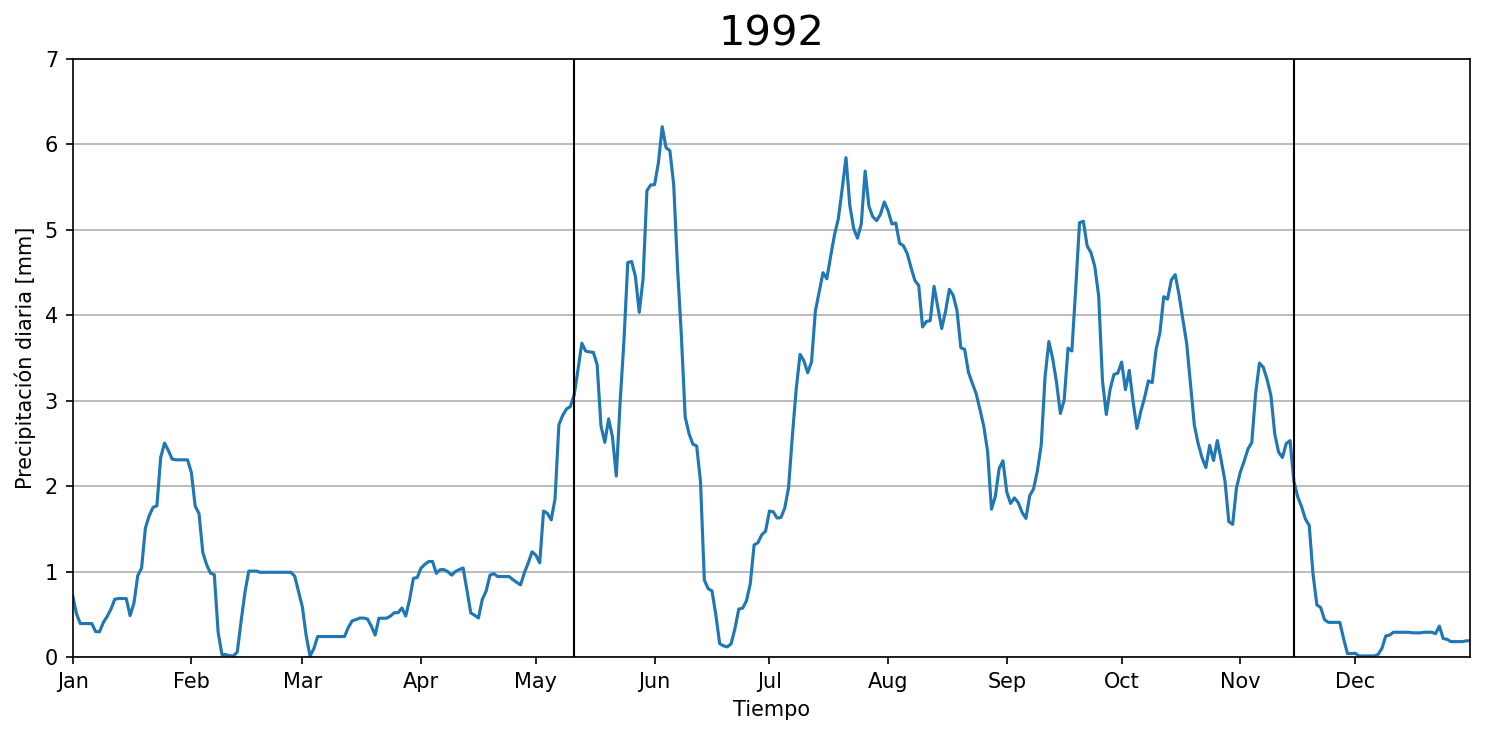

In [8]:
year = 1992
df_year = df_mean_ind[ df_mean_ind.index.year == year ]

# Fechas.
onset = df_year.iloc[:, 1].idxmax()
withdrawal = df_year.iloc[::-1, 1].idxmax()

print(f"Onset     : {onset.day:02d}"
    + f" {onset.month_name()}")
print(f"Withdrawal: {withdrawal.day:02d}"
    + f" {withdrawal.month_name()}")

# Graficamos.
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot(df_year.iloc[:, 0])
#ax.plot(df_year.iloc[:, 1])

# Onset y withdrawal.
ax.plot( (onset, onset),
    ( 0, np.ceil(df_year.iloc[:, 0].max()) ),
    color = "k", linewidth = 1 )
ax.plot( (withdrawal, withdrawal),
    ( 0, np.ceil(df_year.iloc[:, 0].max()) ),
    color = "k", linewidth = 1 ) 

ax.set_title(year, fontsize = 20)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
ax.set_xlim( pd.to_datetime(str(year) + "-01-01"),
    pd.to_datetime(str(year) + "-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()